### Random Forest Implementation from Scratch

# Introduction

### In this notebook, we'll implement a Random Forest algorithm from scratch without using any external libraries. The Random Forest will consist of Decision Trees, and we'll use it for a simple binary classification problem.

## Step 1: Decision Tree Implementation

### Let's start by implementing a basic Decision Tree class. The Decision Tree will be used as a base learner within our Random Forest.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
class DecisionTree:
    def __init__(self, max_depth=None):
        """Initialize the Decision Tree.
        Parameters:
        - max_depth (int): The maximum depth of the tree. If None, the tree will grow until each leaf contains less than 2 samples.
        """
        self.max_depth = max_depth
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None
        self.value = None  # For leaf nodes, store the predicted value

    def fit(self, X, y, depth=0):
        """Fit the Decision Tree to the training data.

        Parameters:
        - X (numpy.ndarray): The input features.
        - y (numpy.ndarray): The target values.
        - depth (int): The current depth of the tree.
        """
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)

        # Check termination conditions
        if (self.max_depth is not None and depth == self.max_depth) or len(unique_classes) == 1 or n_samples < 2:
            # If maximum depth reached, or only one class in the data, create a leaf node
            self.value = unique_classes[0]
            return

        # Find the best split
        best_gini = float('inf')
        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = ~left_mask
                gini = self.calculate_gini_index(y, left_mask, right_mask)

                if gini < best_gini:
                    best_gini = gini
                    self.feature_index = feature_index
                    self.threshold = threshold

        if best_gini == float('inf'):
            # Unable to find a split (all samples have the same feature values)
            self.value = unique_classes[0]
            return

        # Split the data
        left_mask = X[:, self.feature_index] <= self.threshold
        right_mask = ~left_mask
        self.left = DecisionTree(max_depth=self.max_depth)
        self.right = DecisionTree(max_depth=self.max_depth)
        self.left.fit(X[left_mask, :], y[left_mask], depth + 1)
        self.right.fit(X[right_mask, :], y[right_mask], depth + 1)

    def predict(self, X):
        """Make predictions using the trained Decision Tree.

        Parameters:
        - X (numpy.ndarray): The input features for multiple samples.

        Returns:
        - numpy.ndarray: The predicted class labels for each sample.
        """
        if self.value is not None:
            # This node is a leaf node
            return np.full(X.shape[0], self.value)
        else:
            # Traverse the left or right subtree based on the condition
            left_mask = X[:, self.feature_index] <= self.threshold
            right_mask = ~left_mask
            predictions = np.zeros(X.shape[0], dtype=int)
            predictions[left_mask] = self.left.predict(X[left_mask, :])
            predictions[right_mask] = self.right.predict(X[right_mask, :])
            return predictions

    def calculate_gini_index(self, y, left_mask, right_mask):
        """Calculate the Gini index for a split.

        Parameters:
        - y (numpy.ndarray): The target values.
        - left_mask (numpy.ndarray): Boolean mask indicating the samples in the left split.
        - right_mask (numpy.ndarray): Boolean mask indicating the samples in the right split.

        Returns:
        - float: The Gini index.
        """
        left_gini = self.calculate_gini_impurity(y[left_mask])
        right_gini = self.calculate_gini_impurity(y[right_mask])

        left_size = np.sum(left_mask)
        right_size = np.sum(right_mask)
        total_size = left_size + right_size

        gini_index = (left_size / total_size) * left_gini + (right_size / total_size) * right_gini
        return gini_index

    def calculate_gini_impurity(self, y):
        """Calculate the Gini impurity for a node.

        Parameters:
        - y (numpy.ndarray): The target values.

        Returns:
        - float: The Gini impurity.
        """
        unique_classes, class_counts = np.unique(y, return_counts=True)
        probabilities = class_counts / len(y)
        gini_impurity = 1 - np.sum(probabilities ** 2)
        return gini_impurity


## Step 2: Random Forest Implementation
Now, let's implement the Random Forest class, which will consist of multiple Decision Trees.

In [10]:
class RandomForest:
    def __init__(self, n_trees=100, max_depth=None):
        """Initialize the Random Forest.

        Parameters:
        - n_trees (int): The number of Decision Trees in the forest.
        - max_depth (int): The maximum depth of each Decision Tree. If None, the trees will grow until each leaf contains less than 2 samples.
        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        """Fit the Random Forest to the training data.

        Parameters:
        - X (numpy.ndarray): The input features.
        - y (numpy.ndarray): The target values.
        """
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth)
            
            # Implement bootstrap sampling and fit the tree
            n_samples = X.shape[0]
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrapped, y_bootstrapped = X[indices], y[indices]
            
            tree.fit(X_bootstrapped, y_bootstrapped)
            self.trees.append(tree)

    def predict(self, X):
        """Make predictions using the trained Random Forest.

        Parameters:
        - X (numpy.ndarray): The input features.

        Returns:
        - numpy.ndarray: The array of predicted class labels.
        """
        predictions = np.array([tree.predict(X) for tree in self.trees])
        # Use a simple majority voting for classification
        aggregated_predictions = np.mean(predictions, axis=0)
        return np.round(aggregated_predictions).astype(int)


## Step 3: Visualization
We'll create a function to visualize the decision boundaries of our models.

In [11]:
def plot_decision_boundary(X, y, model, title):
    """Plot the decision boundaries of a classification model.

    Parameters:
    - X (numpy.ndarray): The input features.
    - y (numpy.ndarray): The true class labels.
    - model: The trained model (e.g., Decision Tree or Random Forest).
    - title (str): The title of the plot.
    """
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show()


## Step 4: Data Generation and Model Training
Let's generate a synthetic dataset and train our Random Forest on it.

In [12]:
# Generate synthetic data
np.random.seed(42)
X = np.random.rand(100, 2)
y = (X[:, 0] + X[:, 1] > 1).astype(int)

# Split the data into training and testing sets (not needed for this example)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForest(n_trees=100, max_depth=5)
rf_model.fit(X, y)


## Step 5: Evaluation and Visualization
Let's visualize the decision boundaries of our Random Forest.

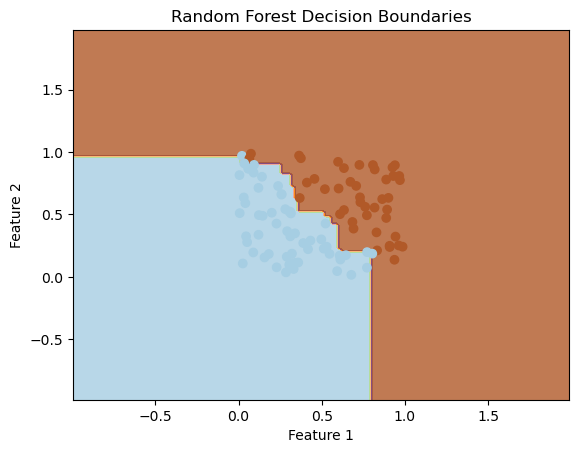

In [13]:
# Visualize the decision boundaries
plot_decision_boundary(X, y, rf_model, 'Random Forest Decision Boundaries')
